# Unique quality assessment title (to be finalised by C3S), including [data stream]-[quality area]-for-[application area]

Production date: 21-05-2024

## 🌍 Use case: Monitor the impact of climate change on weather regimes in the mid-latitudes

## ❓ Quality assessment questions

* **Can I use ERA5 to assess the implications of climate change on weather patterns over Europe and North America?**

### Summary

ERA5 pressure level data are widely used for the analysis of large scale extratropical cyclones activity [[1]](https://doi.org/10.1016/j.oceaneng.2020.108111) [[2]](https://doi.org/10.1002/wea.3861) [[3]](https://doi.org/10.1175/MWR-D-20-0417.1) [[4]](https://doi.org/10.1175/JCLI-D-20-0529.1) [[5]](https://doi.org/10.1002/joc.6957) .

There is an ongoing debate regarding the potential changes in the activity of short-term cyclones in the northern hemisphere due to global warming [[6]](https://doi.org/10.1029/2022JD036952) [[7]](https://doi.org/10.1007/s00382-020-05143-3) [[8]](https://doi.org/10.1002/2013GL058928) [[9]](https://doi.org/10.1175/JCLI3815.1).

The storm tracks refer to the regions where extratropical cyclones exhibit the most intense activity and are closely associated with the occurrence of extreme weather conditions.

This notebook evaluates the description of the storm tracks in the northern hemisphere using ERA5 data and extends the analysis back to 1940 to provide insights into the anticipated changes under a warming scenario [[10]](https://doi.org/10.5194/wcd-3-337-2022).

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* The ERA5 reanalysis data offers an extended historical climate record, enabling the comparison of non-overlapping 30-year reference climatologies. It also allows for testing hypotheses concerning specific changes in atmospheric dynamics associated with ongoing global warming.
* Based on ERA5, long-term alterations in storm track activity imply an intensification of atmospheric variability within the storm track regions due to global warming. This increase in intensity is likely linked to a corresponding rise in the frequency of extreme events. [[11]](https://doi.org/10.1038/srep17491)
```

## 📋 Methodology

In the northern hemisphere, the storm track areas are typically situated over the oceans within a latitudinal band ranging approximately from 30°N to 60°N, and they tend to be more active during the winter season. One way to define the storm track region is by identifying the area with the highest variability in the 500 mbar geopotential height over time scales of 2.5-6 days [[12]](https://doi.org/10.1175/1520-0469(1976)033<1607:ACSSOT>2.0.CO;2). This methodology is complementary to the one adopted for the [operational monitoring of individual storms](https://confluence.ecmwf.int/display/CKB/Windstorm+tracks%3A+Product+User+Guide), which is based on tracking the trajectories of low pressure systems. The specific objective is to compare the patterns of atmospheric circulation and the associated high-frequency variability for the periods 1940-1971 and  1991-2020. 

The analysis and results are organized in the following steps, which are detailed in the sections below:

**[](id1)**
  * Import required packages
  * Define data request
      
**[](id2)**
  * Define a band-pass filter function
  * Datasets retrieval and processing
      
**[](id3)**
  * Display results
  * Discussion 

## 📈 Analysis and results

(id1)=
### 1. Choose the data to use and setup the code

#### Import required packages
Besides the standard libraries `xarray` for the handling of datasets and `matplotlib` for the graphical output, we use `cartopy` for the map projection functions, and the additional function `mpath` included in the package `matplotlib` to crop a round panel around the polar sterographic projection that will be used to display the results.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

from c3s_eqc_automatic_quality_control import diagnostics, download

#### Define data request

The analysis if performed over the northern hemisphere, north of 30°N, and uses the geopotential at 500mb at midnight and at noon.

In [ ]:
collection_id = "reanalysis-era5-pressure-levels"
request = {
    "product_type": "reanalysis",
    "format": "grib",
    "variable": "geopotential",
    "pressure_level": "500",
    "area": [90, -180, 30, 180],
    "time": ["00:00", "12:00"],
}

(id2)=
### 2. Datasets retrieval and computation of some statistics of the 500 mbar geopotential height

#### Define a band-pass filter function

A 2.5-6 days band-pass filter is used, which is implemented as a rolling weighted summation valid for a sampling rate of 12 hours [12]](https://doi.org/10.1175/1520-0469(1976)033<1607:ACSSOT>2.0.CO;2).

In [ ]:
blackmon_weights = [
    -0.00304,
    -0.00013,
    -0.00967,
    -0.01917,
    -0.002,
    0.03043,
    0.03281,
    0.00411,
    0.00335,
    0.04193,
    0.0283,
    -0.09233,
    -0.19477,
    -0.10201,
    0.14335,
    0.27769,
]
blackmon_weights.extend(blackmon_weights[:-1][::-1])

def seasonal_bandpass(ds, weights_mapper, reduction, season):
    ds = ds.where(ds["forecast_reference_time"].dt.season == season, drop=True)
    if weights_mapper:
        ds = diagnostics.rolling_weighted_filter(ds, weights_mapper)
    func = getattr(diagnostics, f"seasonal_weighted_{reduction}")
    return func(ds, weights=False).expand_dims(reduction=[reduction])

#### Datasets retrieval and processing

We define two consecutive 30-year intervals for calculating the statistics of the 500mb geopotential height. By utilizing the extended ERA5 dataset, which now encompasses data dating back to 1940, we can compare two distinct climatological periods that do not overlap. The objective is to identify any changes in the larger-scale circulation patterns. The analysis primarily concentrates on the winter season (December-January-February, DJF), when the storm track regions exhibit heightened variability. A comparable analysis can also be conducted for the remaining seasons.

In [ ]:
# Define climatology periods
years_start = [1941, 1991]
years_stop = [1970, 2020]
assert len(years_start) == len(years_stop)

# Season to plot
season = "DJF"
assert season in ("DJF", "MAM", "JJA", "SON")

The data is retrieved and processed individually for each of the two climatological periods. The reduction to the mean and standard deviation is applied to both the original 12-hourly data and the data that has undergone band-pass filtering.

The retrieval and processing of the data consists of the following steps

1. Download the ERA5 12-hourly values of geopotential at 500mb for the entire time interval 1940-to present
2. Calculate the mean geoptential during winter (DJF) for the period the period 1941-1970
3. Calculate the standard deviation of the geopotential during winter (DJF) for the period the period 1941-1970
4. Calculate the standard deviation of the band-pass filtered (2-6 days) geopotential during winter (DJF) for the period the period 1941-1970
5. Repeat steps 2-to-4 for the period 1991-2020

Subsequently, all the processed data is combined into a unified dataset, which incorporates additional dimensions such as "bandpass" and "reduction" to indicate the specific type of processing applied to the data.

NOTE: The factor $9.8 m/s^2$ is used to convert the geopotential to the corresponding geopotential height. 

In [ ]:
datasets = []
for year_start, year_stop in zip(years_start, years_stop):
    requests = download.update_request_date(
        request, start=f"{year_start}", stop=f"{year_stop}"
    )
    for weights in (None, blackmon_weights):
        weights_mapper = {"forecast_reference_time": weights} if weights else {}
        for reduction in ("mean", "std"):
            print(
                f"{year_start=} {year_stop=} {reduction=} weights={weights is not None}"
            )
            ds = download.download_and_transform(
                collection_id,
                requests,
                transform_func=seasonal_bandpass,
                transform_func_kwargs={
                    "weights_mapper": weights_mapper,
                    "reduction": reduction,
                    "season": season,
                },
                chunks={"year": 1, "time": 1},
                transform_chunks=False,
                concat_dim="forecast_reference_time",
                combine="nested",
            )
            datasets.append(
                ds.expand_dims(
                    bandpass=[True if weights else False],
                    period=[f"{year_start}-{year_stop}"],
                )
            )
da = xr.merge(datasets)["z"].sel(season=season)
with xr.set_options(keep_attrs=True):
    da /= 9.8

(id3)=
### 3. Plot and describe results

#### Display results

For both climatological periods, the average and standard deviation of the original 12-hourly data is examined, as well as the standard deviation of the data that has undergone band-pass filtering. These measurements offer insights into the strength of cyclonic activity within the 2.5-6 day time frame. To visualize the results, contour maps of the 500mb geopotential height are superimposed onto a polar stereographic map depicting the northern hemisphere.

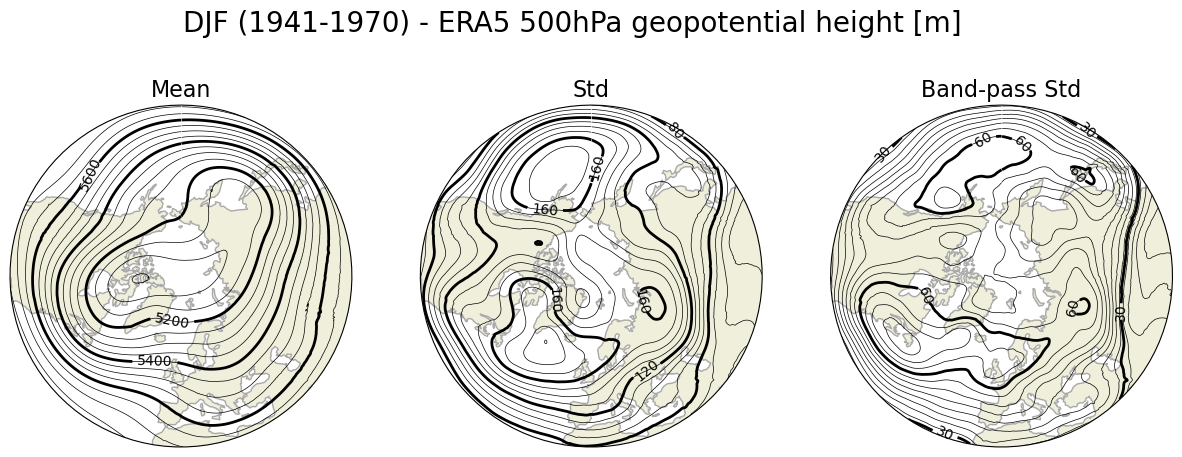

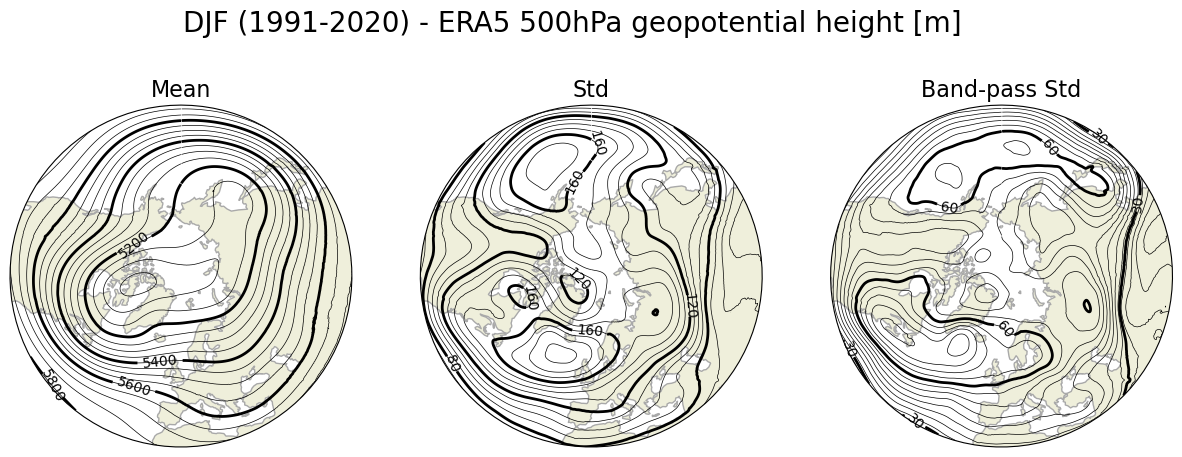

In [8]:
def plot_stormtrack_maps(period, da_period):
    # Circle used to set the boundary
    theta = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    fig, axes = plt.subplots(
        *(1, 3),
        figsize=(15, 7.5),
        subplot_kw={"projection": ccrs.NorthPolarStereo(central_longitude=0)},
    )
    axes = iter(axes.flatten())
    for bandpass, da_bandpass in da_period.groupby("bandpass"):
        for reduction, da_reduction in da_bandpass.groupby("reduction"):
            if reduction == "mean" and not bandpass:
                levels_list = [range(5000, 6000, 50), range(5000, 6000, 200)]
            elif reduction == "std" and not bandpass:
                levels_list = [range(0, 200, 10), range(0, 200, 40)]
            elif reduction == "std" and bandpass:
                levels_list = [range(0, 100, 4), [30, 60]]
            else:
                continue

            ax = next(axes)
            for levels, linewidths in zip(levels_list, [0.5, 2]):
                cs = ax.contour(
                    da_reduction["longitude"],
                    da_reduction["latitude"],
                    da_reduction,
                    levels=levels,
                    colors="k",
                    linewidths=linewidths,
                    linestyles="solid",
                    transform=ccrs.PlateCarree(),
                )
            ax.clabel(cs)
            ax.coastlines(color="darkgray")
            ax.add_feature(cfeature.LAND)
            ax.set_boundary(circle, transform=ax.transAxes)
            ax.set_title(
                f"{'Band-pass ' if bandpass else ''}{reduction.title()}", fontsize=16
            )
    fig.suptitle(
        f"{season} ({period}) - ERA5 500hPa geopotential height [m]",
        fontsize=20,
        y=0.85,
    )
    return fig, axes


for period, da_period in da.groupby("period"):
    plot_stormtrack_maps(period, da_period)
    plt.show()

The **mean** of the 500mb geopotential height (illustrated on the left) offers an initial estimation of the dominant wind direction and intensity. In the absence of topography, the mean atmospheric circulation would exhibit perfect symmetry over a flat Earth. However, the presence of orography introduces ultra-long standing waves that lead to the distinctive tilting of streamlines towards the north (south) upstream (downstream) of the Rocky Mountains. This topographic influence also contributes to the acceleration of airflow (resulting in closer streamlines) off the east coast of North America and over the western Pacific. This aspect of atmospheric circulation is primarily influenced by orography and the Earth's rotation, and it exhibits minimal change between the early and late periods of the reanalysis.

The **standard deviation** of the 500mb geopotential height (shown in the center) identifies regions with the highest variability in atmospheric circulation patterns. However, the standard deviation of the entire 12-hourly geopotential height signal does not differentiate among the various dynamic processes responsible for this variability.

To isolate the variability associated with baroclinic instability, which entails the development of cyclones driven by temperature differences between north and south, in combination with the Earth's rotation, a **band-pass** filter is employed (displayed on the right). The regions with greater variability span the entire North Atlantic and the Pacific Ocean. Comparing the two periods, 1941-1970 and 1991-2020, reveals a slight increase in storm track variability, as well as a slight expansion of the corresponding areas, consistent with the findings of previous studies [[7]](https://doi.org/10.1007/s00382-020-05143-3).



## ℹ️ If you want to know more
### Key resources
* CDS catalogue entries used in this notebook is [ERA5 hourly data on pressure levels from 1940 to present](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-pressure-levels?tab=overview)
* Product [Documentation](https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation) for ERA5 is available

<a id='idBOpen'></a>
Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`, prepared by [BOpen](https://www.bopen.eu/)

### References

[[1]](https://doi.org/10.1016/j.oceaneng.2020.108111) Gramcianinov C.B. , Campos R.M. , de Camargo R. ,  Hodges K.I.,  Guedes Soares C., da Silva Dias P.L. (2020) Analysis of Atlantic extratropical storm tracks characteristics in 41 years of ERA5 and CFSR/CFSv2 databases, Ocean Engineering, Volume 216,108111,
    
[[2]](https://doi.org/10.1002/wea.3861) Walker, E. , Mitchell, D. M., & Seviour, W. J. M. (2020). The numerous approaches to tracking extratropical cyclones and the challenges they present. Weather, 75(11), 336-341.

[[3]](https://doi.org/10.1175/MWR-D-20-0417.1) Crawford, A. D., Schreiber E. A. P. , Sommer N. ,Serreze  M. C. ,  Stroeve J. C., and Barber D. G.  (2021) Sensitivity of Northern Hemisphere Cyclone Detection and Tracking Results to Fine Spatial and Temporal Resolution Using ERA5. Mon. Wea. Rev., 149, 2581–2598.

[[4]](https://doi.org/10.1175/JCLI-D-20-0529.1) Feser, F., O. Krueger, K. Woth, and L. van Garderen (2021) North Atlantic Winter Storm Activity in Modern Reanalyses and Pressure-Based Observations. J. Climate, 34, 2411–2428,

[[5]](https://doi.org/10.1002/joc.6957) Laurila T.K., Sinclair V.A., Gregow H. (2021) Climatology, variability, and trends in near-surface wind speeds over the North Atlantic and Europe during 1979–2018 based on ERA5. Int J Climatol.; 41: 2253–2278.

[[6]](https://doi.org/10.1029/2022JD036952) Karwat, A., Franzke, C. L. E., & Blender, R. (2022). Long-term trends of Northern Hemispheric winter cyclones in the extended ERA5 reanalysis. Journal of Geophysical Research: Atmospheres, 127, e2022JD036952

[[7]](https://doi.org/10.1007/s00382-020-05143-3) Sussman, H. S., Raghavendra, A., Roundy, P. E., & Dai, A. (2020). Trends in northern midlatitude atmospheric wave power from 1950 to 2099. Climate Dynamics, 54(5-6), 2903-2918.

[[8]](https://doi.org/10.1002/2013GL058928) Di Biagio, V., Calmanti, S., Dell'Aquila, A., & Ruti, P. M. (2014). Northern Hemisphere winter midlatitude atmospheric variability in CMIP5 models. Geophysical Research Letters, 41(4), 1277-1282.

[[9]](https://doi.org/10.1175/JCLI3815.1) Bengtsson, L., Hodges, K. I., & Roeckner, E. (2006). Storm tracks and climate change. Journal of climate, 19(15), 3518-3543.

[[10]](https://doi.org/10.5194/wcd-3-337-2022) Priestley, M. D. K. and Catto, J. L.(2022) Future changes in the extratropical storm tracks and cyclone intensity, wind speed, and structure, Weather Clim. Dynam., 3, 337–360

[[11]](https://doi.org/10.1038/srep17491) Lehmann, J., & Coumou, D. (2015). The influence of mid-latitude storm tracks on hot, cold, dry and wet extremes. Sci. Rep., 5, 17491.

[[12]](https://doi.org/10.1175/1520-0469(1976)033<1607:ACSSOT>2.0.CO;2) Blackmon, M. L. (1976). A climatological spectral study of the 500 mb geopotential height of the Northern Hemisphere. Journal of the Atmospheric Sciences, 33(8), 1607-1623.